the length of time a customer remains on a subscription is a key metric for us to
understand how well we’re serving our customers -- if they stay subscribed for a long time, we
know that we’re providing them value.

Of particular interest is how subscription switching behavior is related to
customer retention. In particular, are customers who switch their subscription product more
likely to stay subscribed for longer? Does that vary based on which products they’re switching
from and to?

- `ID` - the id of the subscription, uniquely identifies rows 
- `viewable_product_id` - the identifier of the product the customer is subscribed to
- `created_at` - the timestamp indicating when the subscription started 
- `quantity` - the number of items sybscriped to (eg a customer could have one subscription to two foaming shave gels) 
- `user_id` - uniquely identifies a single customer and will appear multiple times for customers with multiple subscriptions 
- `removed_at` - timestamp indicating when that subscription ended. The column will be blank for subscriptions that havent eneded 
- `created_by_client_type` - was this subscription created by the customer on the web or by a customer experience associate via admin 
- `removed_by_client_type` - was this subscription remvoed by the customer on the web or by a customer experience associate via admin 

- a customer is considered retained untill all of their subscriptions are ended 
- if, for one customer, you see a particular subscription end and a new subscritopn stat at the same time, thats considered a switch 
- customers can also add additional products to their subscrition 

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

#pandas - DataFrames to organize our data
import pandas as pd 
#numpy - linear algebra and matrices for python
import numpy as np  
#matplotlib - workhorse plotting library
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,6
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
#seaborn - easy plotting for statistical visualizations, based on plt
import seaborn as sns
import re 

In [2]:
# Suppress all warnings just to keep the notebook nice and clean. 
# This must happen after all imports since numpy actually adds its
# RankWarning class back in.
import warnings
warnings.filterwarnings("ignore")

In [80]:
# data path
datapath1 = "harrys.xlsx"
datapath2= "harrys_product.xlsx"

In [81]:
# load the excel data into a dataframe
data1 = pd.read_excel(datapath1)
data2 = pd.read_excel(datapath2)

In [82]:
# get info on the data
print('Dataframe dimensions:', data1.shape)
tab_info=pd.DataFrame(data1.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(data1.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(data1.isnull().sum()/data1.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
display(data1[:2])

Dataframe dimensions: (9967, 8)


,id,viewable_product_id,created_at,quantity,user_id,removed_at,created_by_client_type,removed_by_client_type
column type,int64,int64,datetime64[ns],int64,int64,datetime64[ns],object,object
null values (nb),0,0,0,0,0,6372,0,6449
null values (%),0,0,0,0,0,63.931,0,64.7035


,id,viewable_product_id,created_at,quantity,user_id,removed_at,created_by_client_type,removed_by_client_type
0,1493735,511,2016-07-28 12:34:42.906,1,36867,NaT,www,NaN
1,1607724,490,2016-08-28 19:00:06.840,1,42060,NaT,www,NaN


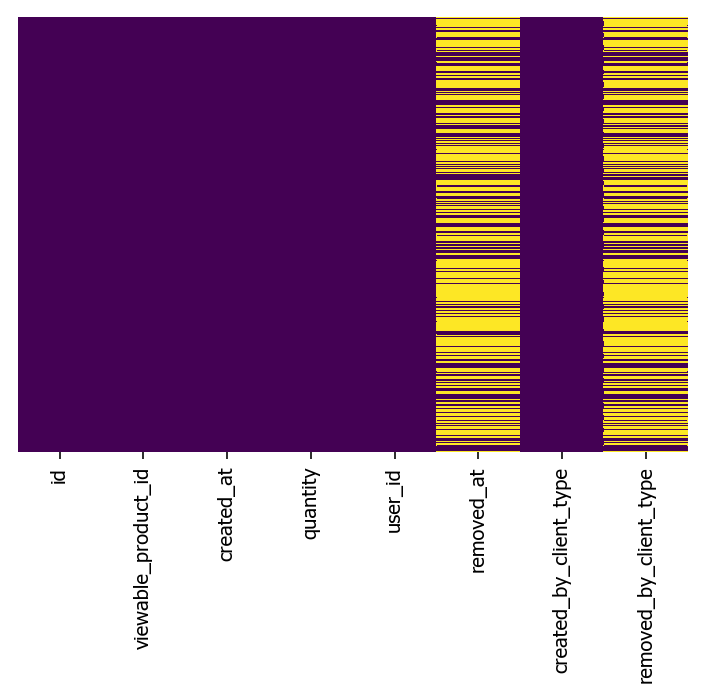

In [83]:
# check for null values visually 
sns.heatmap(data1.isnull(), yticklabels=False, cbar=False, cmap='viridis') 
plt.show()

In [84]:
# print head 
data1.head()

,id,viewable_product_id,created_at,quantity,user_id,removed_at,created_by_client_type,removed_by_client_type
0,1493735,511,2016-07-28 12:34:42.906,1,36867,NaT,www,NaN
1,1607724,490,2016-08-28 19:00:06.840,1,42060,NaT,www,NaN
2,1539095,511,2016-08-10 20:02:59.016,1,52992,2016-12-05 21:31:19.158,www,www
3,1515988,511,2016-08-04 12:47:41.972,1,65654,2016-09-12 11:20:09.225,www,www
4,1495173,511,2016-07-28 19:49:50.478,1,95304,NaT,www,NaN


In [85]:
# get info on the data
print('Dataframe dimensions:', data2.shape)
tab_info=pd.DataFrame(data2.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(data2.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(data1.isnull().sum()/data1.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
display(data1[:2])

Dataframe dimensions: (18, 15)


,aftershave_count,blade_count,face_lotion_count,face_wash_count,handle_count,lipbalm_count,other_set_count,razorstand_count,shave_cream_count,shave_gel_count,...,created_at,created_by_client_type,id,quantity,removed_at,removed_by_client_type,user_id,viewable_product_id,price,abbrev
column type,object,object,object,object,object,object,object,object,object,object,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,int64,object
null values (nb),0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
null values (%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,63.930972,64.703522,0.0,0.0,NaN,NaN


,id,viewable_product_id,created_at,quantity,user_id,removed_at,created_by_client_type,removed_by_client_type
0,1493735,511,2016-07-28 12:34:42.906,1,36867,NaT,www,NaN
1,1607724,490,2016-08-28 19:00:06.840,1,42060,NaT,www,NaN


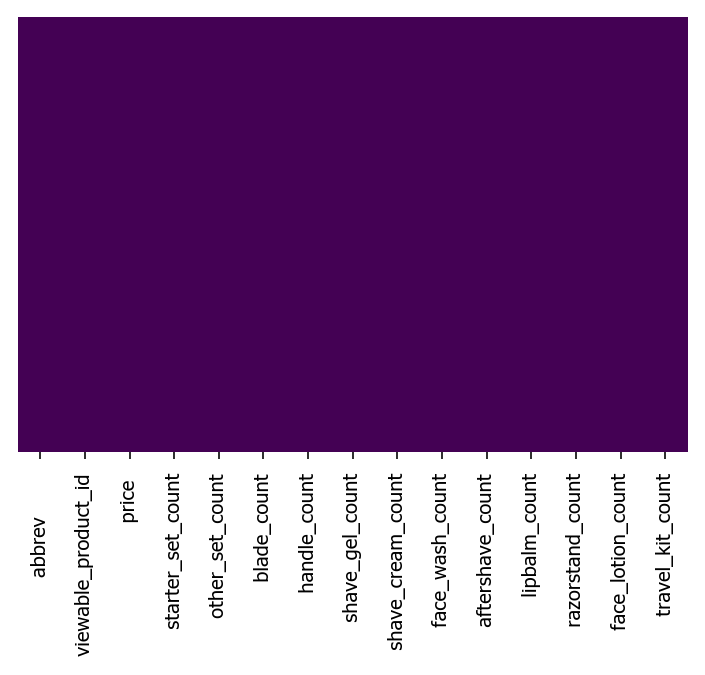

In [86]:
# check for null values visually 
sns.heatmap(data2.isnull(), yticklabels=False, cbar=False, cmap='viridis') 
plt.show()

In [87]:
data2

,abbrev,viewable_product_id,price,starter_set_count,other_set_count,blade_count,handle_count,shave_gel_count,shave_cream_count,face_wash_count,aftershave_count,lipbalm_count,razorstand_count,face_lotion_count,travel_kit_count
0,ShaveCream,110,8,0,0,0,0,0,1,0,0,0,0,0,0
1,ShaveCream,120,12,0,0,0,0,0,1,0,0,0,0,0,0
2,DailyFaceWash,318,7,0,0,0,0,0,0,1,0,0,0,0,0
3,DailyFaceLotionSPF15,446,8,0,0,0,0,0,0,0,0,0,0,1,0
4,HarrysBlades,488,8,0,0,4,0,0,0,0,0,0,0,0,0
5,HarrysBlades,489,16,0,0,8,0,0,0,0,0,0,0,0,0
6,HarrysBlades,490,28,0,0,16,0,0,0,0,0,0,0,0,0
7,Blades2GelsPlan,504,27,0,0,8,0,2,0,0,0,0,0,0,0
8,"Blades,Gel,PostShave",505,32,0,0,8,0,2,0,0,1,0,0,0,0
9,FoamingShaveGel,506,6,0,0,0,0,1,0,0,0,0,0,0,0


# get to know the variables 

In [88]:
data1.columns

Index(['id', 'viewable_product_id', 'created_at', 'quantity', 'user_id',
       'removed_at', 'created_by_client_type', 'removed_by_client_type'],
      dtype='object')

In [89]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9967 entries, 0 to 9966
Data columns (total 8 columns):
id                        9967 non-null int64
viewable_product_id       9967 non-null int64
created_at                9967 non-null datetime64[ns]
quantity                  9967 non-null int64
user_id                   9967 non-null int64
removed_at                3595 non-null datetime64[ns]
created_by_client_type    9967 non-null object
removed_by_client_type    3518 non-null object
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 623.0+ KB


We see some NaTs in the `removed_at` datetime column and some NaNs that we will have to deal with. But first lets get a better idea of each of the variables we will be working with. 

In [28]:
data1.id.nunique()

9967

In [ ]:
# create index of user_id + transaction id 

In [107]:
newindex_id = data1.id.astype(str) + data1.user_id.astype(str) #creates newindex_id

In [109]:
data3 = data1.copy() # creates a copy of the df called data3

In [110]:
data3.index = newindex_id # sets the index 

In [111]:
data3.head()

,id,viewable_product_id,created_at,quantity,user_id,removed_at,created_by_client_type,removed_by_client_type
149373536867,1493735,511,2016-07-28 12:34:42.906,1,36867,NaT,www,NaN
160772442060,1607724,490,2016-08-28 19:00:06.840,1,42060,NaT,www,NaN
153909552992,1539095,511,2016-08-10 20:02:59.016,1,52992,2016-12-05 21:31:19.158,www,www
151598865654,1515988,511,2016-08-04 12:47:41.972,1,65654,2016-09-12 11:20:09.225,www,www
149517395304,1495173,511,2016-07-28 19:49:50.478,1,95304,NaT,www,NaN


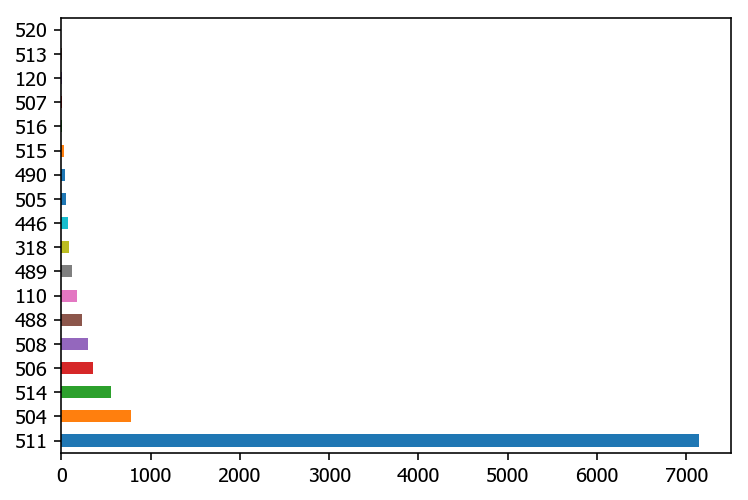

In [11]:
# product types and their frequency 
data1.viewable_product_id.value_counts().plot(kind='barh')

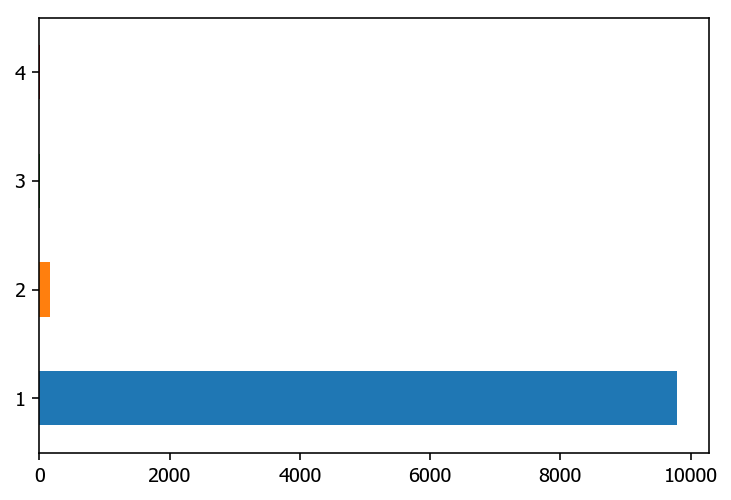

In [12]:
data1.quantity.value_counts().plot(kind='barh')

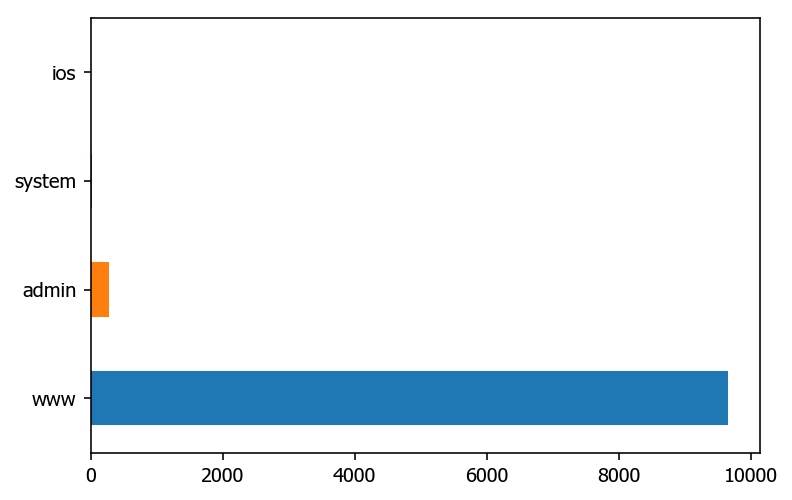

In [13]:
data1.created_by_client_type.value_counts().plot(kind='barh')

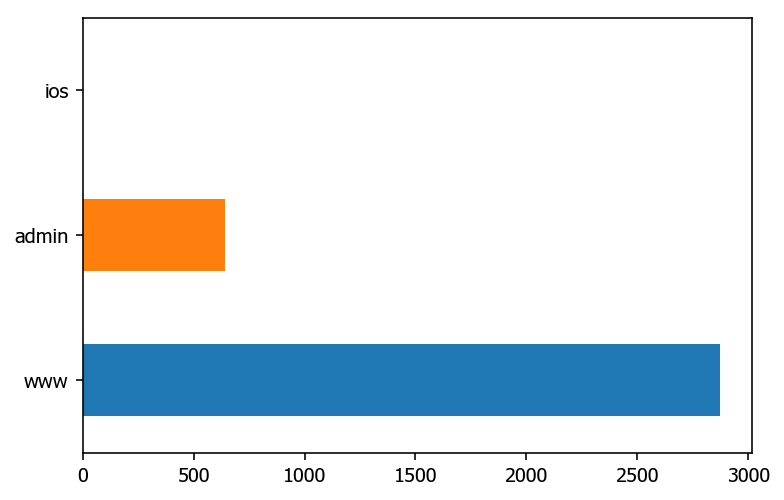

In [14]:
data1.removed_by_client_type.value_counts().plot(kind='barh')

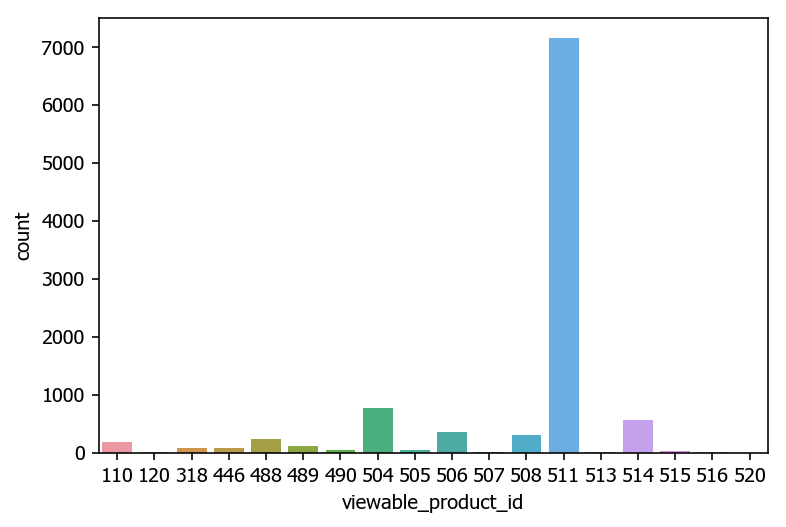

In [48]:
sns.countplot(x=data1["viewable_product_id"],data=data1)
plt.show()

In [34]:
data1.user_id.nunique()

7702

In [35]:
import datetime 
from dateutil import parser 

In [36]:
print("Earliest Date:",data1.created_at.min(), "\n", "Latest Date:",data1.created_at.max(), "\n",  \
"Number of days in between them:", data1.created_at.max() - data1.created_at.min())

Earliest Date: 2016-07-22 00:02:21.127000 
 Latest Date: 2017-02-01 22:54:52.268000 
 Number of days in between them: 194 days 22:52:31.141000


In [37]:
data1.index 
data1["weekday"] = data1["created_at"].dt.weekday
data1["weekday_name"] = data1["created_at"].dt.weekday_name
data1["time_through_day"] = data1["created_at"].map(lambda x: x - datetime.datetime.combine(x.date(), datetime.time()))
data1["fraction_through_day"] = data1["time_through_day"].map(lambda x: x / datetime.timedelta(hours = 24))
data1["hours_through_day"] = data1["fraction_through_day"] * 24
data1["days_through_week"] = data1.apply(lambda row: row["weekday"] + row["fraction_through_day"], axis = 1)
data1["fraction_through_week"] = data1["days_through_week"] / 24

Int64Index([1493735, 1607724, 1539095, 1515988, 1495173, 1541667, 1506388,
            1876092, 1547256, 1576048,
            ...
            1591776, 1596400, 1599994, 1601115, 1602161, 1607498, 1607862,
            1608561, 1616909, 1616918],
           dtype='int64', name='id', length=9967)

In [38]:
data1.head()

,viewable_product_id,created_at,quantity,user_id,removed_at,created_by_client_type,removed_by_client_type,weekday,weekday_name,time_through_day,fraction_through_day,hours_through_day,days_through_week,fraction_through_week
id,,,,,,,,,,,,,,
1493735,511,2016-07-28 12:34:42.906,1,36867,NaT,www,NaN,3,Thursday,12:34:42.906000,0.524108,12.578585,3.524108,0.146838
1607724,490,2016-08-28 19:00:06.840,1,42060,NaT,www,NaN,6,Sunday,19:00:06.840000,0.791746,19.001900,6.791746,0.282989
1539095,511,2016-08-10 20:02:59.016,1,52992,2016-12-05 21:31:19.158,www,www,2,Wednesday,20:02:59.016000,0.835405,20.049727,2.835405,0.118142
1515988,511,2016-08-04 12:47:41.972,1,65654,2016-09-12 11:20:09.225,www,www,3,Thursday,12:47:41.972000,0.533125,12.794992,3.533125,0.147214
1495173,511,2016-07-28 19:49:50.478,1,95304,NaT,www,NaN,3,Thursday,19:49:50.478000,0.826279,19.830688,3.826279,0.159428


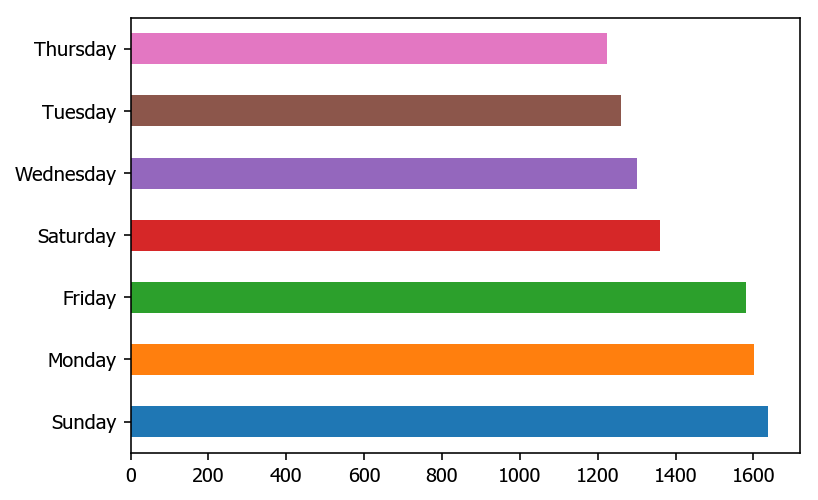

In [39]:
data1.weekday_name.value_counts().plot(kind='barh')

In [40]:
# group by viewable_product_id 
data1.groupby('viewable_product_id')

In [64]:
# to view groups 
data1.groupby('user_id').groups

{968: Int64Index([1507701], dtype='int64', name='id'),
 5404: Int64Index([1526753], dtype='int64', name='id'),
 7938: Int64Index([1489315], dtype='int64', name='id'),
 17951: Int64Index([1526391, 2050396, 2050416, 2050417, 2050418], dtype='int64', name='id'),
 19323: Int64Index([1447565, 1482407], dtype='int64', name='id'),
 19468: Int64Index([1490024], dtype='int64', name='id'),
 20407: Int64Index([1524039], dtype='int64', name='id'),
 30813: Int64Index([1537149], dtype='int64', name='id'),
 32786: Int64Index([1529058, 1529059, 1714909], dtype='int64', name='id'),
 33316: Int64Index([1528798], dtype='int64', name='id'),
 36867: Int64Index([1493735], dtype='int64', name='id'),
 42060: Int64Index([1607724], dtype='int64', name='id'),
 44155: Int64Index([1473383, 1474035, 1547023], dtype='int64', name='id'),
 49526: Int64Index([1493405], dtype='int64', name='id'),
 52992: Int64Index([1539095], dtype='int64', name='id'),
 54410: Int64Index([1582518, 1760831, 1760832, 1760833], dtype='int6

In [42]:
# iterating through groups 
grouped = data1.groupby('viewable_product_id')
for viewable_product_id, group_name in grouped:
    print(viewable_product_id)
    print(group_name)

110
         viewable_product_id              created_at  quantity  user_id  \
id                                                                        
1614549                  110 2016-08-30 16:00:12.043         2   387414   
1679209                  110 2016-09-21 17:55:27.081         1   794893   
1644350                  110 2016-09-09 19:50:32.908         2   145058   
1587483                  110 2016-08-24 19:36:30.760         2   502973   
1833948                  110 2016-11-11 16:52:31.614         1  1022245   
1549125                  110 2016-08-13 19:08:49.431         2  1336929   
1869027                  110 2016-11-21 13:56:54.417         1  1701951   
1869028                  110 2016-11-21 13:57:34.139         1  1701951   
1616967                  110 2016-08-31 12:12:47.421         2   627977   
1491862                  110 2016-07-27 19:02:04.809         1  1200557   
1513808                  110 2016-08-03 18:18:45.767         1  1200557   
1547553              

         viewable_product_id              created_at  quantity  user_id  \
id                                                                        
1523438                  505 2016-08-06 16:37:02.026         1   794893   
1761055                  505 2016-10-19 02:57:51.461         1  1107060   
1906926                  505 2016-12-04 12:43:56.404         1  2098977   
1743192                  505 2016-10-14 14:29:55.028         1   215329   
1618427                  505 2016-08-31 18:53:17.419         1   752737   
1612591                  505 2016-08-29 23:32:56.069         1  2532201   
1830480                  505 2016-11-10 17:43:31.527         1  2548989   
1865167                  505 2016-11-20 14:22:01.133         1  2562834   
1507802                  505 2016-08-01 21:17:33.770         1   985669   
1513334                  505 2016-08-03 16:07:04.348         1  1430895   
1586624                  505 2016-08-24 18:20:50.647         1  1771931   
1535474                  

In [79]:
data1.head()

,viewable_product_id,created_at,quantity,removed_at,created_by_client_type,removed_by_client_type,weekday,weekday_name,time_through_day,fraction_through_day,hours_through_day,days_through_week,fraction_through_week
user_id,,,,,,,,,,,,,
968,511,2016-08-01 20:52:35.770,1,NaT,www,NaN,0,Monday,20:52:35.770000,0.869858,20.876603,0.869858,0.036244
5404,504,2016-08-07 18:25:11.394,1,NaT,www,NaN,6,Sunday,18:25:11.394000,0.767493,18.419832,6.767493,0.281979
7938,511,2016-07-26 22:07:14.249,1,2016-11-08 14:51:27.497,www,www,1,Tuesday,22:07:14.249000,0.921693,22.120625,1.921693,0.080071
17951,511,2017-01-20 01:22:12.123,1,2017-01-20 01:22:21.384,www,www,4,Friday,01:22:12.123000,0.057085,1.370034,4.057085,0.169045
17951,110,2017-01-20 01:22:12.116,1,2017-01-20 01:22:21.367,www,www,4,Friday,01:22:12.116000,0.057085,1.370032,4.057085,0.169045


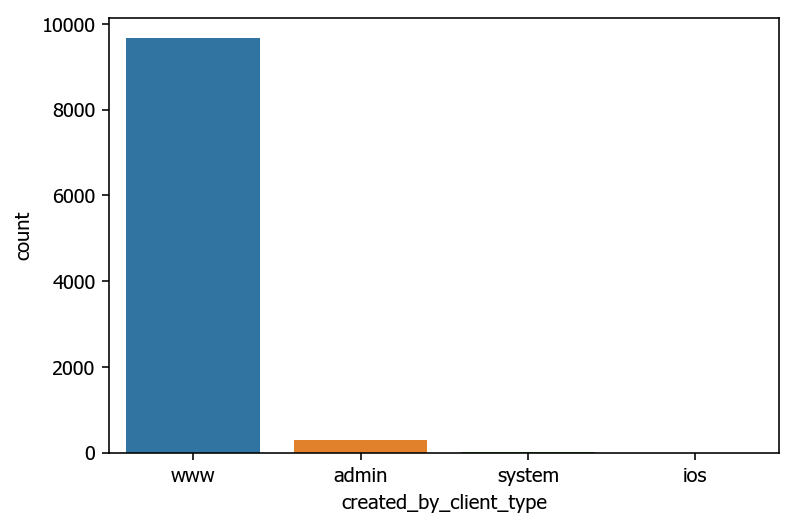

In [49]:
sns.countplot(x=data1["created_by_client_type"],data=data1)
plt.show()

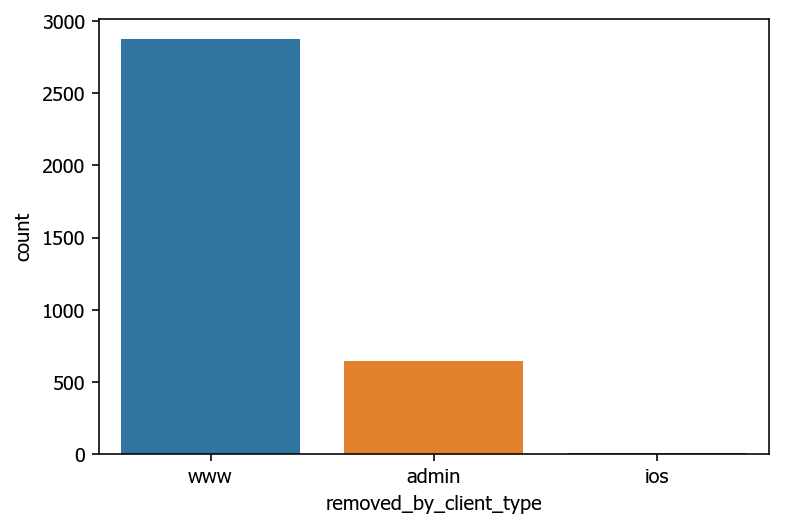

In [50]:
sns.countplot(x=data1["removed_by_client_type"],data=data1)
plt.show()

In [55]:
data1.columns

Index(['viewable_product_id', 'created_at', 'quantity', 'user_id',
       'removed_at', 'created_by_client_type', 'removed_by_client_type',
       'weekday', 'weekday_name', 'time_through_day', 'fraction_through_day',
       'hours_through_day', 'days_through_week', 'fraction_through_week'],
      dtype='object')

In [56]:
data2.columns

Index(['        abbrev        ', ' viewable_product_id ', '  price  ',
       ' starter_set_count ', ' other_set_count ', ' blade_count ',
       ' handle_count ', ' shave_gel_count ', ' shave_cream_count ',
       ' face_wash_count ', ' aftershave_count ', ' lipbalm_count ',
       ' razorstand_count ', ' face_lotion_count ', ' travel_kit_count '],
      dtype='object')

In [57]:
data2

,abbrev,viewable_product_id,price,starter_set_count,other_set_count,blade_count,handle_count,shave_gel_count,shave_cream_count,face_wash_count,aftershave_count,lipbalm_count,razorstand_count,face_lotion_count,travel_kit_count
0,ShaveCream,110,8,0,0,0,0,0,1,0,0,0,0,0,0
1,ShaveCream,120,12,0,0,0,0,0,1,0,0,0,0,0,0
2,DailyFaceWash,318,7,0,0,0,0,0,0,1,0,0,0,0,0
3,DailyFaceLotionSPF15,446,8,0,0,0,0,0,0,0,0,0,0,1,0
4,HarrysBlades,488,8,0,0,4,0,0,0,0,0,0,0,0,0
5,HarrysBlades,489,16,0,0,8,0,0,0,0,0,0,0,0,0
6,HarrysBlades,490,28,0,0,16,0,0,0,0,0,0,0,0,0
7,Blades2GelsPlan,504,27,0,0,8,0,2,0,0,0,0,0,0,0
8,"Blades,Gel,PostShave",505,32,0,0,8,0,2,0,0,1,0,0,0,0
9,FoamingShaveGel,506,6,0,0,0,0,1,0,0,0,0,0,0,0


In [60]:
#rename dataframe columns
data2.rename(columns={'        abbrev        ': 'abbrev', 
                      ' viewable_product_id ': 'viewable_product_id', 
                      '  price  ': 'price', 
                      ' starter_set_count ': 'starter_set_count', 
                      ' other_set_count ': 'other_set_count', 
                      ' blade_count ': 'blade_count',
                      ' handle_count ': 'handle_count', 
                      ' shave_gel_count ': 'shave_gel_count', 
                      ' shave_cream_count ': 'shave_cream_count', 
                      ' face_wash_count ': 'face_wash_count',
                      ' aftershave_count ': 'aftershave_count',
                      ' lipbalm_count ': 'lipbalm_count',
                      ' razorstand_count ': 'razorstand_count',
                      ' face_lotion_count ': 'face_lotion_count',
                      ' travel_kit_count ': 'travel_kit_count'
                     }, 
             inplace=True)

In [61]:
data2.columns

Index(['        abbrev        ', 'viewable_product_id', '  price  ',
       'starter_set_count', 'other_set_count', 'blade_count', 'handle_count',
       'shave_gel_count', 'shave_cream_count', 'face_wash_count',
       'aftershave_count', 'lipbalm_count', 'razorstand_count',
       'face_lotion_count', 'travel_kit_count'],
      dtype='object')

In [77]:
data1.head()

,viewable_product_id,created_at,quantity,removed_at,created_by_client_type,removed_by_client_type,weekday,weekday_name,time_through_day,fraction_through_day,hours_through_day,days_through_week,fraction_through_week
user_id,,,,,,,,,,,,,
968,511,2016-08-01 20:52:35.770,1,NaT,www,NaN,0,Monday,20:52:35.770000,0.869858,20.876603,0.869858,0.036244
5404,504,2016-08-07 18:25:11.394,1,NaT,www,NaN,6,Sunday,18:25:11.394000,0.767493,18.419832,6.767493,0.281979
7938,511,2016-07-26 22:07:14.249,1,2016-11-08 14:51:27.497,www,www,1,Tuesday,22:07:14.249000,0.921693,22.120625,1.921693,0.080071
17951,511,2017-01-20 01:22:12.123,1,2017-01-20 01:22:21.384,www,www,4,Friday,01:22:12.123000,0.057085,1.370034,4.057085,0.169045
17951,110,2017-01-20 01:22:12.116,1,2017-01-20 01:22:21.367,www,www,4,Friday,01:22:12.116000,0.057085,1.370032,4.057085,0.169045


In [66]:
data1.set_index('user_id', inplace=True)

In [67]:
data1.head()

,viewable_product_id,created_at,quantity,removed_at,created_by_client_type,removed_by_client_type,weekday,weekday_name,time_through_day,fraction_through_day,hours_through_day,days_through_week,fraction_through_week
user_id,,,,,,,,,,,,,
36867,511,2016-07-28 12:34:42.906,1,NaT,www,NaN,3,Thursday,12:34:42.906000,0.524108,12.578585,3.524108,0.146838
42060,490,2016-08-28 19:00:06.840,1,NaT,www,NaN,6,Sunday,19:00:06.840000,0.791746,19.001900,6.791746,0.282989
52992,511,2016-08-10 20:02:59.016,1,2016-12-05 21:31:19.158,www,www,2,Wednesday,20:02:59.016000,0.835405,20.049727,2.835405,0.118142
65654,511,2016-08-04 12:47:41.972,1,2016-09-12 11:20:09.225,www,www,3,Thursday,12:47:41.972000,0.533125,12.794992,3.533125,0.147214
95304,511,2016-07-28 19:49:50.478,1,NaT,www,NaN,3,Thursday,19:49:50.478000,0.826279,19.830688,3.826279,0.159428


In [70]:
data1 = data1.sort_index().head()

In [74]:
data1.head()

,viewable_product_id,created_at,quantity,removed_at,created_by_client_type,removed_by_client_type,weekday,weekday_name,time_through_day,fraction_through_day,hours_through_day,days_through_week,fraction_through_week
user_id,,,,,,,,,,,,,
968,511,2016-08-01 20:52:35.770,1,NaT,www,NaN,0,Monday,20:52:35.770000,0.869858,20.876603,0.869858,0.036244
5404,504,2016-08-07 18:25:11.394,1,NaT,www,NaN,6,Sunday,18:25:11.394000,0.767493,18.419832,6.767493,0.281979
7938,511,2016-07-26 22:07:14.249,1,2016-11-08 14:51:27.497,www,www,1,Tuesday,22:07:14.249000,0.921693,22.120625,1.921693,0.080071
17951,511,2017-01-20 01:22:12.123,1,2017-01-20 01:22:21.384,www,www,4,Friday,01:22:12.123000,0.057085,1.370034,4.057085,0.169045
17951,110,2017-01-20 01:22:12.116,1,2017-01-20 01:22:21.367,www,www,4,Friday,01:22:12.116000,0.057085,1.370032,4.057085,0.169045


In [75]:
data1.index

Int64Index([968, 5404, 7938, 17951, 17951], dtype='int64', name='user_id')

In [76]:
data1.index.is_unique

False

In [78]:
data1.columns

Index(['viewable_product_id', 'created_at', 'quantity', 'removed_at',
       'created_by_client_type', 'removed_by_client_type', 'weekday',
       'weekday_name', 'time_through_day', 'fraction_through_day',
       'hours_through_day', 'days_through_week', 'fraction_through_week'],
      dtype='object')